# Basic Usage

The FireANTs library relies on robust packages like `SimpleITK` and `nibabel` to load images, thereby supporting a lot of image formats. Let's start by importing the packages. 

In [1]:
%load_ext autoreload
%autoreload 2
from fireants.io import Image, BatchedImages
from fireants.registration.affine import AffineRegistration
from fireants.registration.greedy import GreedyRegistration
import matplotlib.pyplot as plt
import SimpleITK as sitk
from time import time

USE_FFO: True
FFO_AVAILABLE: True
Using FFO: True


In [2]:
# load the images
image1 = Image.load_file("atlas_2mm_1000_3.nii.gz")
image2 = Image.load_file("atlas_2mm_1001_3.nii.gz")
# batchify them (we only have a single image per batch, but we can pass multiple images)
batch1 = BatchedImages([image1])
batch2 = BatchedImages([image2])

In [3]:
# check device name
print(batch1().device)

cuda:0


### Coordinate systems in torch and physical space

Pixels in PyTorch tensors are indexed with coordinate values in the range `[-1, 1]` (see [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) for details).
Meanwhile, medical imaging modalities typically reside in physical coordinate systems which may be important especially in multi-modal settings.

The `Image` objects therefore contain additional metadata to transform coordiantes from physical coordiantes to torch coordinates (`phy2torch`) and torch to physical (`torch2phy`). These variables are used internally, and the user does not need to worry about them, but can use them for further analysis.

In [4]:
print(image1.phy2torch)
print(image1.torch2phy)
print(image1.phy2torch @ image1.torch2phy)

tensor([[[-0.0105,  0.0000,  0.0000, -0.0105],
         [ 0.0000, -0.0087,  0.0000,  0.0087],
         [ 0.0000,  0.0000,  0.0079, -0.0079],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')
tensor([[[ -95.,    0.,    0.,   -1.],
         [   0., -115.,    0.,    1.],
         [   0.,    0.,  127.,    1.],
         [   0.,    0.,    0.,    1.]]], device='cuda:0')
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]], device='cuda:0')


(-0.5, 115.5, -0.5, 127.5)

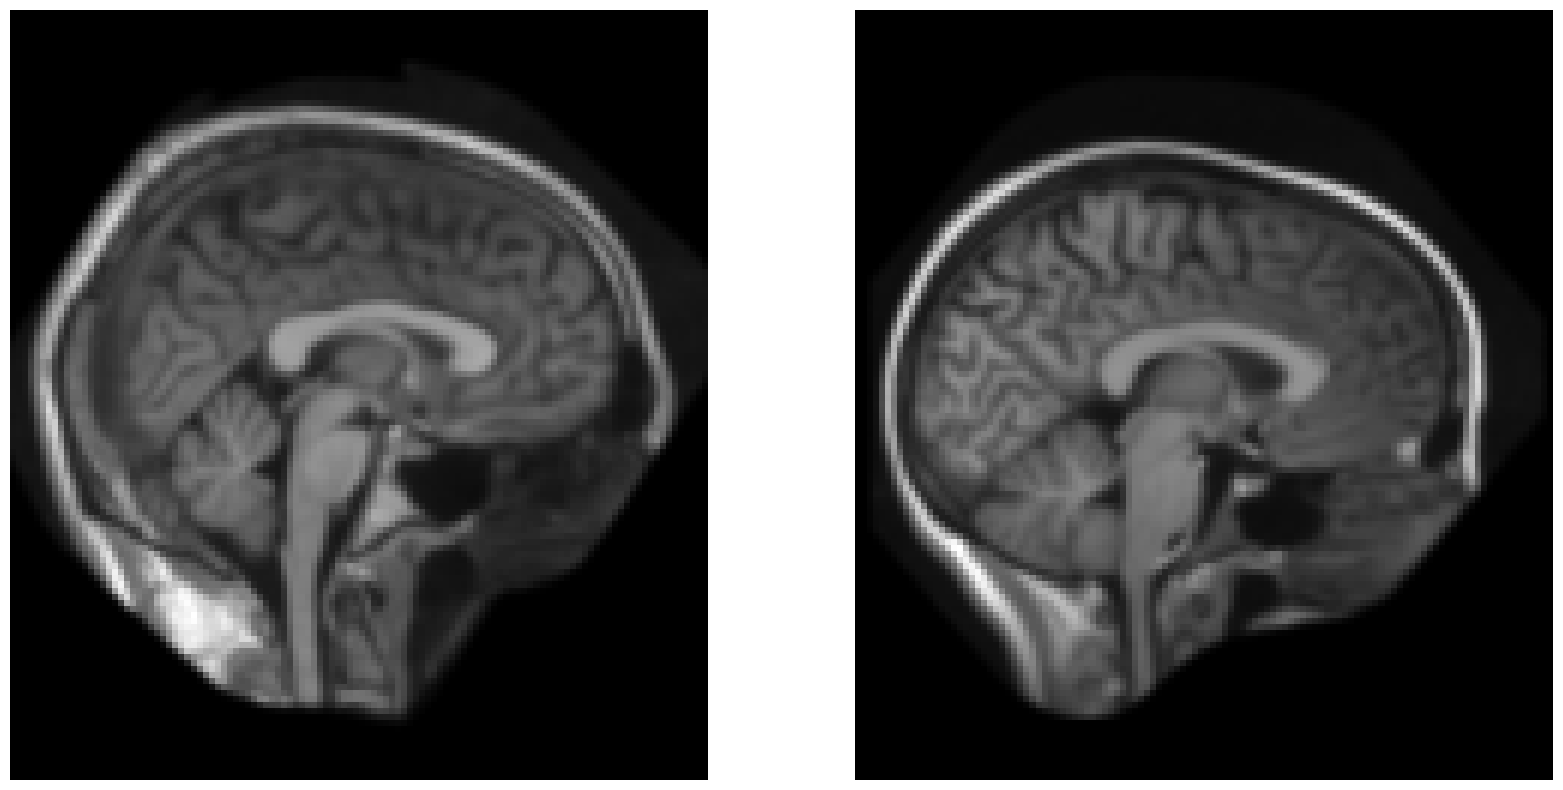

In [5]:
# visualize the images
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(batch1()[0, 0, :, :, 48].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(batch2()[0, 0, :, :, 48].cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')

### Now let's do some registration

In [6]:
# specify some values
scales = [4, 2, 1]  # scales at which to perform registration
iterations = [200, 100, 50]
optim = 'Adam'
lr = 3e-3

# create affine registration object
affine = AffineRegistration(scales, iterations, batch1, batch2, optimizer=optim, optimizer_lr=lr,
                            cc_kernel_size=5)

INFO:fireants.registration.abstract:Registration of type AffineRegistration initialized with dtype torch.float32


In [8]:
# run registration
start = time()
affine.optimize()
end = time()

scale: 1, iter: 49/50, loss: -0.643590: 100%|██████████| 50/50 [00:00<00:00, 83.31it/s]


In [9]:
print("Runtime", end - start, "seconds")

Runtime 1.668825626373291 seconds


In [11]:
moved = affine.evaluate(batch1, batch2)

Text(0.5, 1.0, 'Moving Image')

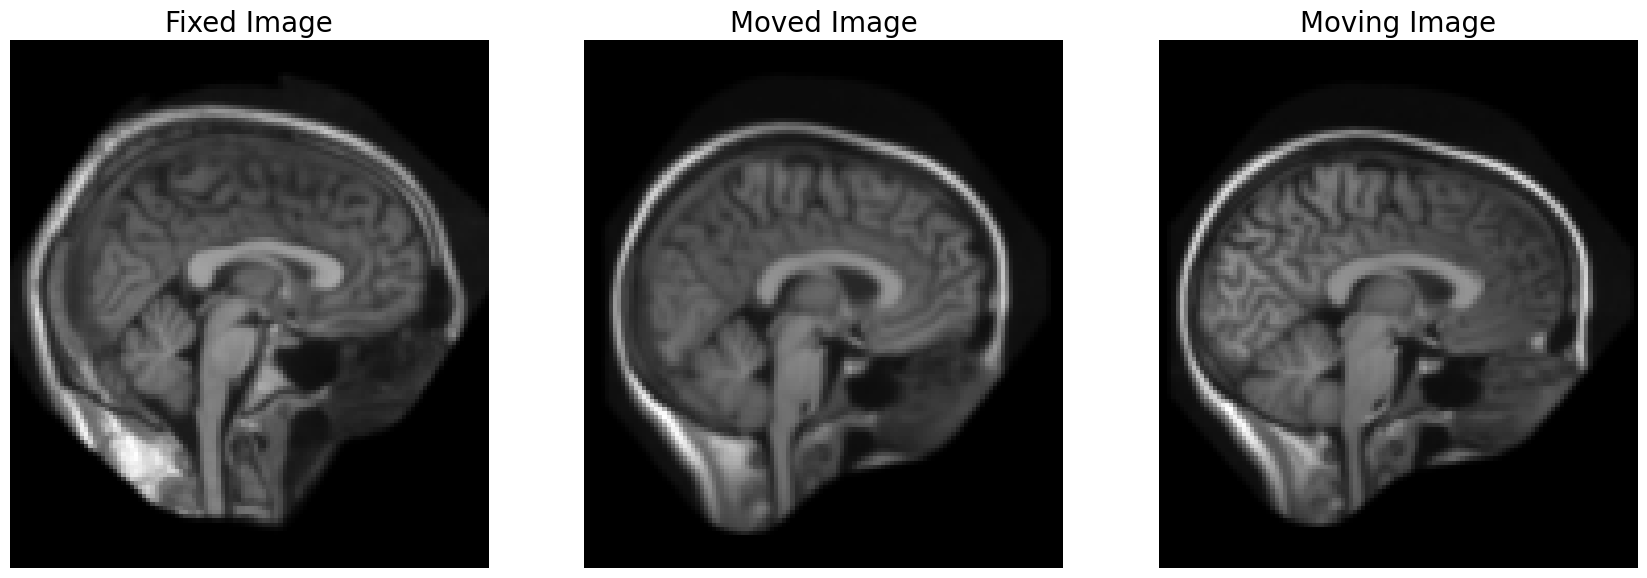

In [12]:
# visualize the images
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(batch1()[0, 0, :, :, 48].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(moved[0, 0, :, :, 48].detach().cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(batch2()[0, 0, :, :, 48].cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
# set titles
ax[0].set_title("Fixed Image", fontsize=20)
ax[1].set_title("Moved Image", fontsize=20)
ax[2].set_title("Moving Image", fontsize=20)

Text(0.5, 1.0, 'Moving Image')

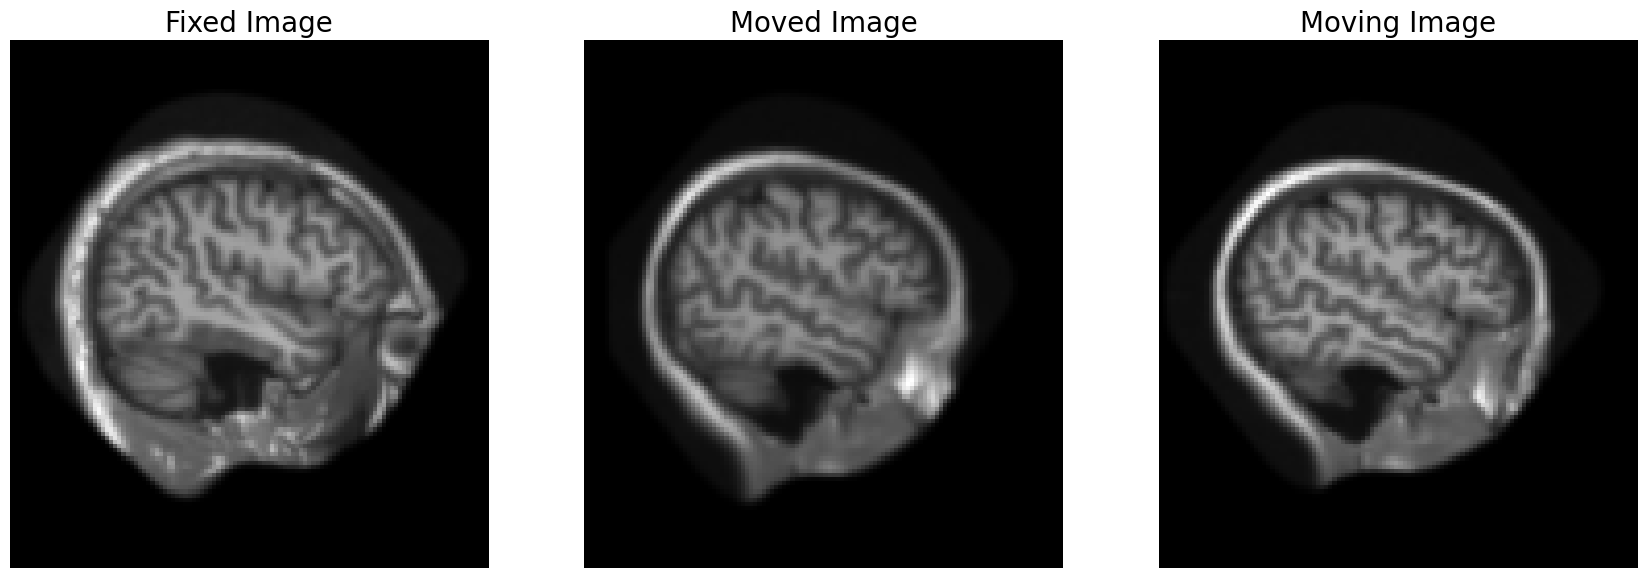

In [13]:
# visualize the images
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(batch1()[0, 0, :, :, 70].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(moved[0, 0, :, :, 70].detach().cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(batch2()[0, 0, :, :, 70].cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
# set titles
ax[0].set_title("Fixed Image", fontsize=20)
ax[1].set_title("Moved Image", fontsize=20)
ax[2].set_title("Moving Image", fontsize=20)

# Let's run deformable registration

The affine transform aligned the moving image to overlap more with the fixed image, but there wasn't much to align in the first place. Therefore, only the anterior portion of the skull seems a little deformed.

Let's run deformable registration and see the difference.

In [19]:
reg = GreedyRegistration(scales=[4, 2, 1], iterations=[200, 100, 25], 
            fixed_images=batch1, moving_images=batch2,
            cc_kernel_size=5, deformation_type='compositive', 
            smooth_grad_sigma=0.5, 
            optimizer='adam', optimizer_lr=0.5, init_affine=affine.get_affine_matrix().detach())

INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32


In [20]:
start = time()
reg.optimize()
end = time()

scale: 1, iter: 24/25, loss: -0.833909: 100%|██████████| 25/25 [00:00<00:00, 67.94it/s]


In [21]:
print("Runtime", end - start, "seconds")

Runtime 1.06431245803833 seconds


In [22]:
# get moved image
moved = reg.evaluate(batch1, batch2)

Text(0.5, 1.0, 'Moving Image')

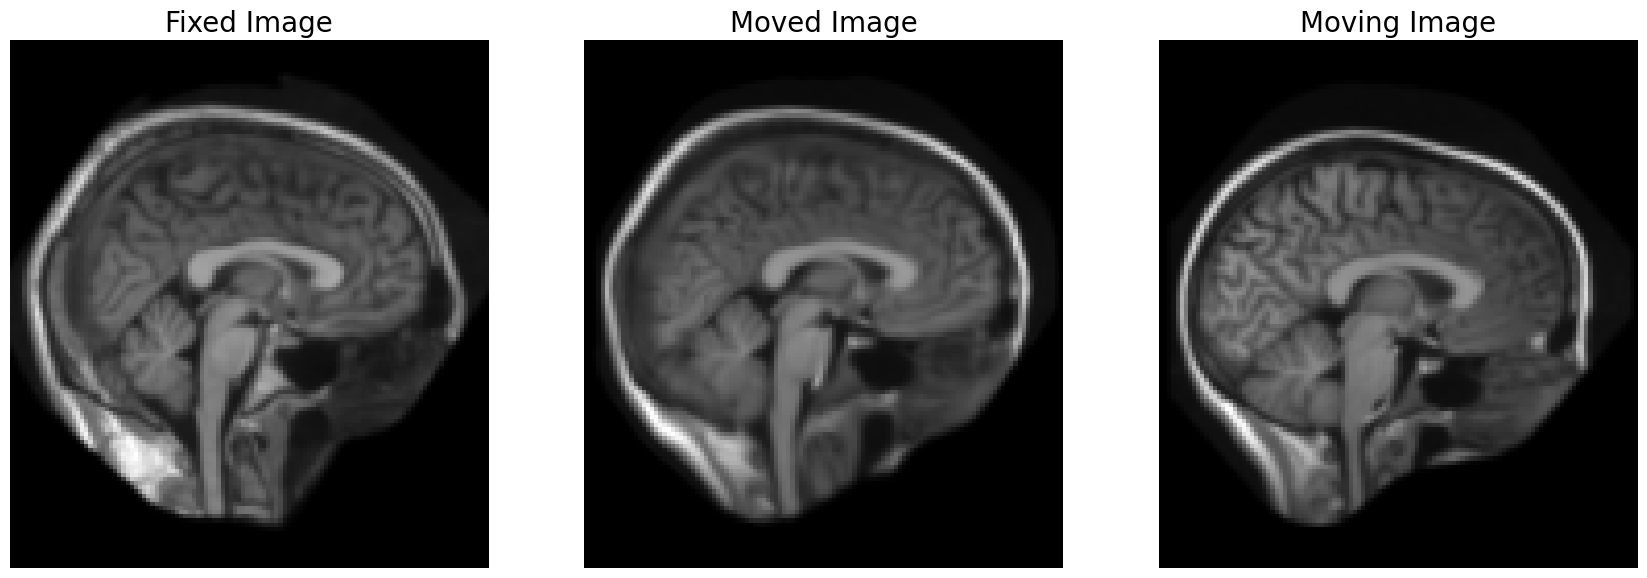

In [23]:
# visualize the images
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(batch1()[0, 0, :, :, 48].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(moved[0, 0, :, :, 48].detach().cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(batch2()[0, 0, :, :, 48].cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
# set titles
ax[0].set_title("Fixed Image", fontsize=20)
ax[1].set_title("Moved Image", fontsize=20)
ax[2].set_title("Moving Image", fontsize=20)

# Write out warp as ants image

In [24]:
reg.save_as_ants_transforms("1000_1001_warp.nii.gz")

In [25]:
w = sitk.ReadImage("1000_1001_warp.nii.gz")
w = sitk.GetArrayFromImage(w)
print(w.min(), w.max())

-12.898202 15.229565


In [26]:
!antsApplyTransforms -d 3 -i atlas_2mm_1001_3.nii.gz -r atlas_2mm_1000_3.nii.gz -t 1000_1001_warp.nii.gz -o antsMoved.nii.gz

In [27]:
antsmoved = Image.load_file("antsMoved.nii.gz")

Text(0.5, 1.0, 'Moving Image')

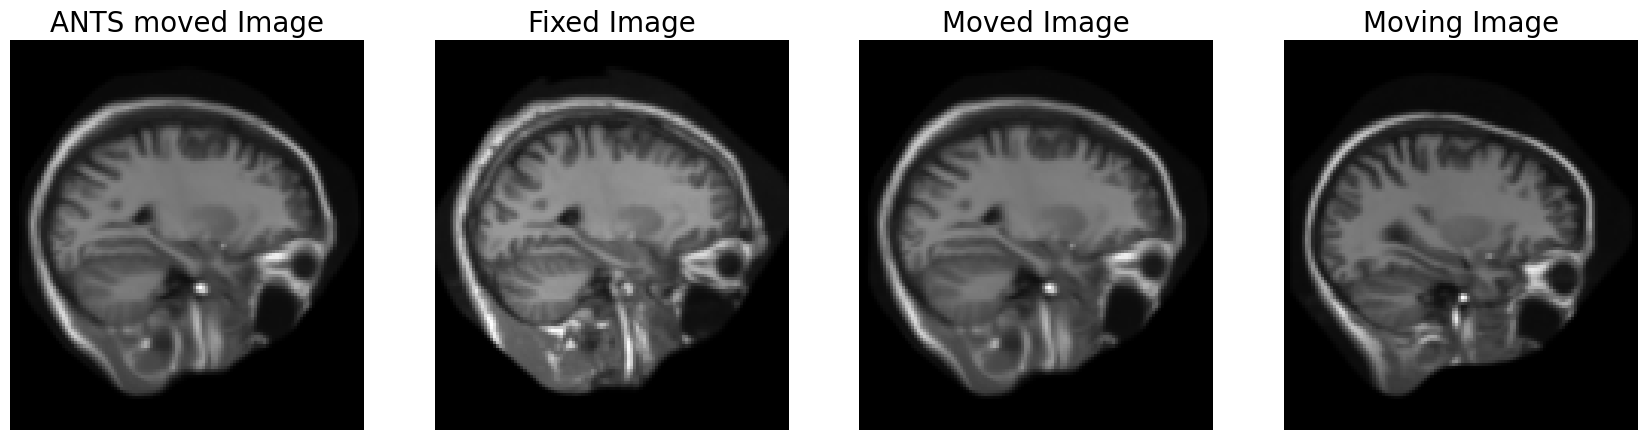

In [28]:
# visualize the images
fig, ax = plt.subplots(1, 4, figsize=(21, 7))
idx = 60
ax[0].imshow(antsmoved.array[0, 0, :, :, idx].cpu().numpy(), 'gray'); ax[0].invert_yaxis(); ax[0].axis('off')
ax[1].imshow(batch1()[0, 0, :, :, idx].cpu().numpy(), 'gray'); ax[1].invert_yaxis(); ax[1].axis('off')
ax[2].imshow(moved[0, 0, :, :, idx].detach().cpu().numpy(), 'gray'); ax[2].invert_yaxis(); ax[2].axis('off')
ax[3].imshow(batch2()[0, 0, :, :, idx].detach().cpu().numpy(), 'gray'); ax[3].invert_yaxis(); ax[3].axis('off')

# set titles
ax[0].set_title("ANTS moved Image", fontsize=20)
ax[1].set_title("Fixed Image", fontsize=20)
ax[2].set_title("Moved Image", fontsize=20)
ax[3].set_title("Moving Image", fontsize=20)

In [29]:
(antsmoved.array - moved).abs().mean()

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

# Write out the moved images 

In [31]:
from fireants.io import FakeBatchedImages

In [32]:
#### This is deprecated in favor of using `FakeBatchedImages` instead
# reference_img = sitk.ReadImage("atlas_2mm_1000_3.nii.gz")

# # Preparing the moving image to be written out
# moved_image_np = moved[0, 0].detach().cpu().numpy() # volumes are typically stored in tensors with dimensions [Batch, Channels, Depth, Height, Width], so extracting the latter 3 for nifti
# moved_sitk_image = sitk.GetImageFromArray(moved_image_np)
# moved_sitk_image.SetOrigin(reference_img.GetOrigin())
# moved_sitk_image.SetSpacing(reference_img.GetSpacing())
# moved_sitk_image.SetDirection(reference_img.GetDirection())
# sitk.WriteImage(moved_sitk_image, 'reslice_deform_atlas_2mm_1000_3.nii.gz')

# this instantiates the tensor `moved` with the metadata of `batch1`
moved_batch = FakeBatchedImages(moved, batch1)
moved_batch.write_image("reslice_deform_atlas_2mm_1000_3.nii.gz")


INFO:fireants.io.image:Saved image to reslice_deform_atlas_2mm_1000_3.nii.gz


Rank 0 is acquiring lock
Rank 0 is releasing lock


Note the moved image looks a lot more like the fixed image now. Let's see if the diffeomorphic constraint is satisfied.

## Check diffeomorphism

In [33]:
from fireants.utils.imageutils import jacobian
import torch

In [34]:
warp = reg.get_warped_coordinates(batch1, batch2)

In [35]:
# we're padding it because the jacobian values are not correct on the boundaries due to zero padding
jac = jacobian(warp).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1, :]
print(jac.shape)

torch.Size([1, 126, 114, 94, 3, 3])


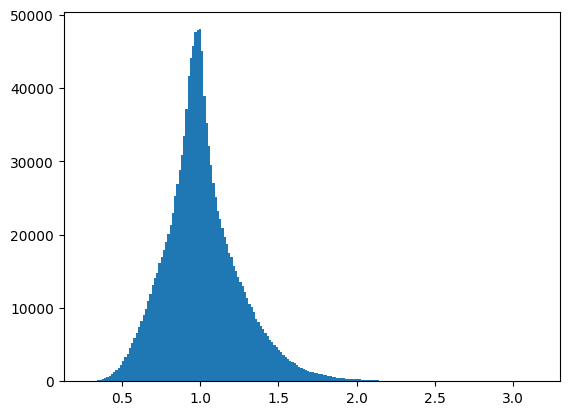

In [36]:
det = torch.linalg.det(jac).reshape(-1).data.cpu().numpy()
_ = plt.hist(det, bins=200)

In [37]:
print((det<=0).mean())

0.0


Note that the determinant histogram follows a distribution centered around 1, and no pixel contains a non-positive determinant, meaning the transformation is fully diffeomorphic.